# Data Exploration
In this notebook, data will be explore to get a better understanding of the data, and to make vizualizations for the report.

In [2]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [12]:
#Load the ratings file
ratings = pd.read_csv('../data/title.ratings.tsv', sep='\t')
titles = pd.read_csv('../data/title.basics.tsv', sep='\t')

In [13]:
# Only keep ratings with tconst as movie
ratings =ratings.merge(titles[titles['titleType'] == 'movie'], on='tconst', how='inner')

## Vote binning
Create vote segments using log-based bins for better distribution

These bins are also used for the model evaluation.

In [14]:
# Define vote bins based on log scale and percentiles
# This creates more balanced segments for model evaluation
vote_bins = [
    (0, 10, "Very Low (≤10)"),
    (10, 25, "Low (11-25)"),
    (25, 50, "Low-Medium (26-50)"),
    (50, 100, "Medium (51-100)"),
    (100, 250, "Medium-High (101-250)"),
    (250, 500, "High (251-500)"),
    (500, 1000, "High (501-1K)"),
    (1000, 2500, "Very High (1K-2.5K)"),
    (2500, 5000, "Very High (2.5K-5K)"),
    (5000, 10000, "Popular (5K-10K)"),
    (10000, 25000, "Popular (10K-25K)"),
    (25000, 50000, "Very Popular (25K-50K)"),
    (50000, 100000, "Very Popular (50K-100K)"),
    (100000, float('inf'), "Blockbuster (100K+)")
]

# Create segment labels
def assign_vote_segment(num_votes):
    """Assign a vote segment label based on number of votes"""
    for min_votes, max_votes, label in vote_bins:
        if min_votes <= num_votes < max_votes:
            return label
    return "Blockbuster (100K+)"  # fallback

ratings['vote_segment'] = ratings['numVotes'].apply(assign_vote_segment)

# Display segment distribution
print("Vote Segment Distribution:\n")
# Print segment counts in the order of vote_bins (not alphabetical)
segment_counts = ratings['vote_segment'].value_counts()
for _, _, label in vote_bins:
    count = segment_counts.get(label, 0)
    pct = (count / len(ratings)) * 100
    print(f"{label:30s}: {count:8,} movies ({pct:5.2f}%)")
print(f"\nTotal: {len(ratings):,} movies")


Vote Segment Distribution:

Very Low (≤10)                :   25,401 movies ( 7.52%)
Low (11-25)                   :   77,502 movies (22.93%)
Low-Medium (26-50)            :   51,303 movies (15.18%)
Medium (51-100)               :   42,754 movies (12.65%)
Medium-High (101-250)         :   46,288 movies (13.69%)
High (251-500)                :   27,117 movies ( 8.02%)
High (501-1K)                 :   20,691 movies ( 6.12%)
Very High (1K-2.5K)           :   19,193 movies ( 5.68%)
Very High (2.5K-5K)           :    9,468 movies ( 2.80%)
Popular (5K-10K)              :    6,187 movies ( 1.83%)
Popular (10K-25K)             :    5,100 movies ( 1.51%)
Very Popular (25K-50K)        :    2,523 movies ( 0.75%)
Very Popular (50K-100K)       :    1,838 movies ( 0.54%)
Blockbuster (100K+)           :    2,636 movies ( 0.78%)

Total: 338,001 movies


## Percentage of votes
In this section, the percentage of votes will be calculated to see how many movies have more than 150 votes, and how many have fewer than 40 votes.

In [15]:
# Calculate exact percentages for the claim
# Claim: ~20% have more than 150 reviews, ~60% receive fewer than 40 reviews

pct_less_than_40 = (ratings['numVotes'] < 40).sum() / len(ratings) * 100
pct_more_than_150 = (ratings['numVotes'] > 150).sum() / len(ratings) * 100
print(f"Movies with fewer than 40 reviews: {pct_less_than_40:.2f}%")
print(f"Movies with more than 150 reviews: {pct_more_than_150:.2f}%")
print()
print(f"Total movies: {len(ratings):,}")
print(f"Movies with < 40 reviews: {(ratings['numVotes'] < 40).sum():,}")
print(f"Movies with > 150 reviews: {(ratings['numVotes'] > 150).sum():,}")

Movies with fewer than 40 reviews: 41.08%
Movies with more than 150 reviews: 35.13%

Total movies: 338,001
Movies with < 40 reviews: 138,852
Movies with > 150 reviews: 118,733


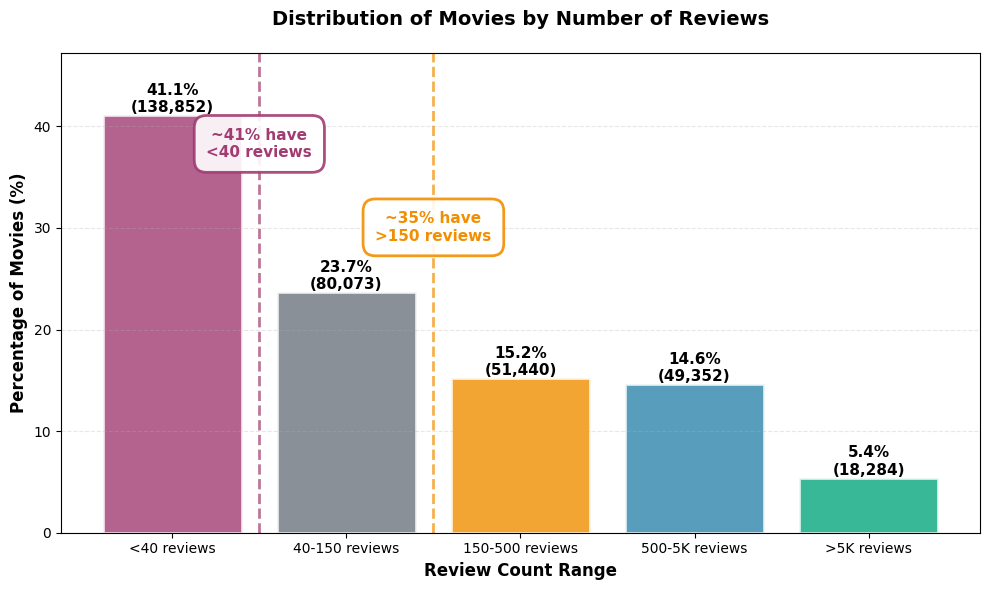

In [16]:
fig, ax = plt.subplots(figsize=(10, 6))

# Create bins that highlight the key thresholds
bins = [0, 40, 150, 500, 5000, float('inf')]
bin_labels = ['<40 reviews', '40-150 reviews', '150-500 reviews', '500-5K reviews', '>5K reviews']
colors = ['#A23B72', '#6C757D', '#F18F01', '#2E86AB', '#06A77D']

# Calculate percentages for each bin
bin_counts = []
bin_percentages = []
for i in range(len(bins)-1):
    if bins[i+1] == float('inf'):  # Last bin (open-ended)
        count = (ratings['numVotes'] >= bins[i]).sum()
    else:
        count = ((ratings['numVotes'] >= bins[i]) & (ratings['numVotes'] < bins[i+1])).sum()
    pct = (count / len(ratings)) * 100
    bin_counts.append(count)
    bin_percentages.append(pct)

# Create bar chart
bars = ax.bar(bin_labels, bin_percentages, color=colors, edgecolor='white', linewidth=2, alpha=0.8)

# Add percentage labels on bars
for i, (bar, pct, count) in enumerate(zip(bars, bin_percentages, bin_counts)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{pct:.1f}%\n({count:,})',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

# Highlight the key thresholds with annotations
ax.axvline(x=0.5, color='#A23B72', linestyle='--', linewidth=2, alpha=0.7, zorder=0)
ax.axvline(x=1.5, color='#F18F01', linestyle='--', linewidth=2, alpha=0.7, zorder=0)

# Add text annotations for key statistics
ax.text(0.5, max(bin_percentages) * 0.9, f'~{pct_less_than_40:.0f}% have\n<40 reviews', 
        ha='center', fontsize=11, fontweight='bold', color='#A23B72',
        bbox=dict(boxstyle='round,pad=0.8', facecolor='white', edgecolor='#A23B72', linewidth=2, alpha=0.9))
ax.text(1.5, max(bin_percentages) * 0.7, f'~{pct_more_than_150:.0f}% have\n>150 reviews', 
        ha='center', fontsize=11, fontweight='bold', color='#F18F01',
        bbox=dict(boxstyle='round,pad=0.8', facecolor='white', edgecolor='#F18F01', linewidth=2, alpha=0.9))

ax.set_ylabel('Percentage of Movies (%)', fontsize=12, fontweight='bold')
ax.set_xlabel('Review Count Range', fontsize=12, fontweight='bold')
ax.set_title('Distribution of Movies by Number of Reviews', fontsize=14, fontweight='bold', pad=20)
ax.set_ylim(0, max(bin_percentages) * 1.15)
ax.grid(True, alpha=0.3, linestyle='--', axis='y')
ax.tick_params(labelsize=10)

plt.tight_layout()
#plt.savefig('../vote_distribution_simple_appendix.png', dpi=300, bbox_inches='tight')
plt.show()

#print(f"\nSimplified visualization saved as 'vote_distribution_simple_appendix.png'")


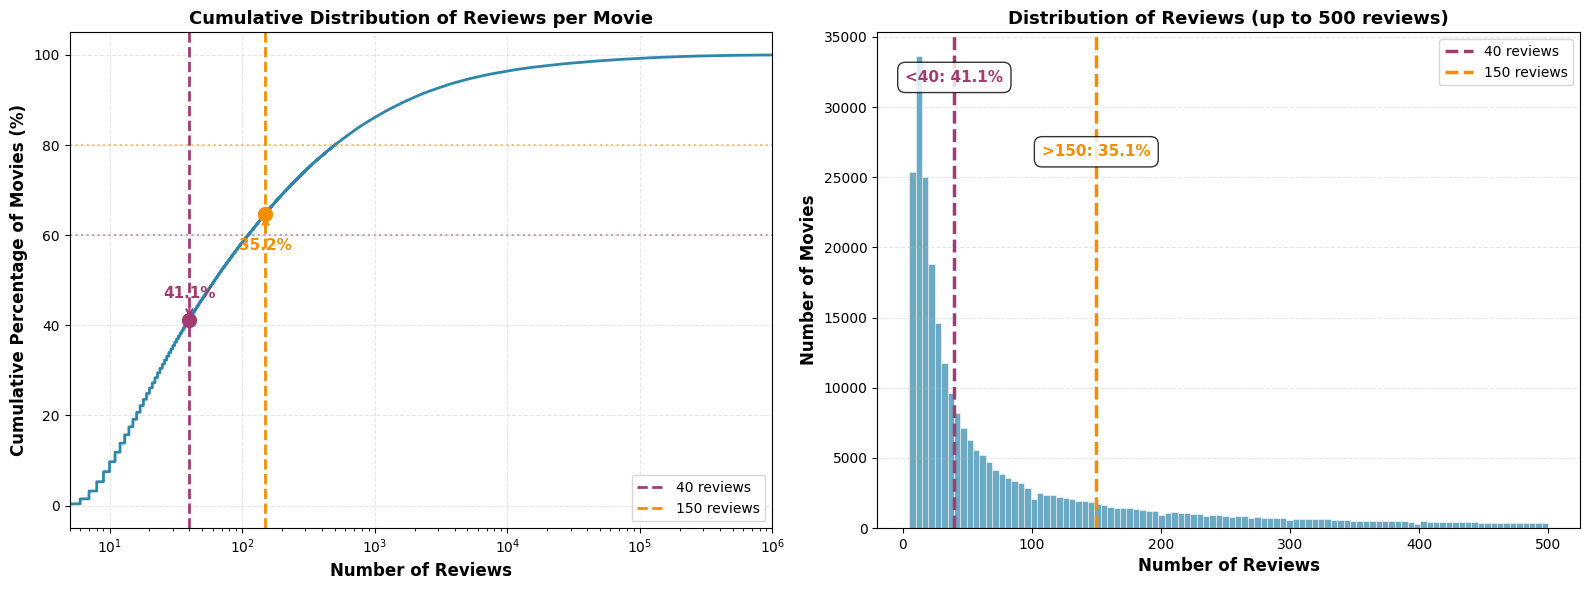


Visualization saved as 'vote_distribution_appendix.png'

Key Statistics:
  • 41.1% of movies have fewer than 40 reviews
  • 35.1% of movies have more than 150 reviews


In [17]:
# Create publication-ready visualization for appendix
# Shows the distribution of reviews and highlights the key thresholds

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Left plot: Cumulative Distribution Function (CDF)
sorted_votes = np.sort(ratings['numVotes'].values)
percentiles = np.arange(1, len(sorted_votes) + 1) / len(sorted_votes) * 100

axes[0].plot(sorted_votes, percentiles, linewidth=2, color='#2E86AB')
axes[0].axvline(x=40, color='#A23B72', linestyle='--', linewidth=2, label='40 reviews')
axes[0].axvline(x=150, color='#F18F01', linestyle='--', linewidth=2, label='150 reviews')
axes[0].axhline(y=60, color='#A23B72', linestyle=':', alpha=0.5)
axes[0].axhline(y=80, color='#F18F01', linestyle=':', alpha=0.5)

# Find and annotate the exact points
idx_40 = np.searchsorted(sorted_votes, 40)
pct_at_40 = (idx_40 / len(sorted_votes)) * 100
idx_150 = np.searchsorted(sorted_votes, 150)
pct_at_150 = (idx_150 / len(sorted_votes)) * 100

axes[0].plot(40, pct_at_40, 'o', color='#A23B72', markersize=10, zorder=5)
axes[0].plot(150, pct_at_150, 'o', color='#F18F01', markersize=10, zorder=5)
axes[0].annotate(f'{pct_at_40:.1f}%', xy=(40, pct_at_40), 
                xytext=(40, pct_at_40 + 5), fontsize=11, fontweight='bold',
                ha='center', color='#A23B72',
                arrowprops=dict(arrowstyle='->', color='#A23B72', lw=1.5))
axes[0].annotate(f'{100-pct_at_150:.1f}%', xy=(150, pct_at_150), 
                xytext=(150, pct_at_150 - 8), fontsize=11, fontweight='bold',
                ha='center', color='#F18F01',
                arrowprops=dict(arrowstyle='->', color='#F18F01', lw=1.5))

axes[0].set_xlabel('Number of Reviews', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Cumulative Percentage of Movies (%)', fontsize=12, fontweight='bold')
axes[0].set_title('Cumulative Distribution of Reviews per Movie', fontsize=13, fontweight='bold')
axes[0].set_xscale('log')
axes[0].set_xlim(5, 1000000)
axes[0].grid(True, alpha=0.3, linestyle='--')
axes[0].legend(fontsize=10, loc='lower right')
axes[0].tick_params(labelsize=10)

# Right plot: Histogram with key thresholds highlighted
# Focus on the range up to 500 votes for better visibility
votes_subset = ratings[ratings['numVotes'] <= 500]['numVotes']
axes[1].hist(votes_subset, bins=100, color='#2E86AB', edgecolor='white', linewidth=0.5, alpha=0.7)
axes[1].axvline(x=40, color='#A23B72', linestyle='--', linewidth=2.5, label='40 reviews')
axes[1].axvline(x=150, color='#F18F01', linestyle='--', linewidth=2.5, label='150 reviews')

# Add text annotations
axes[1].text(40, axes[1].get_ylim()[1] * 0.9, f'<40: {pct_less_than_40:.1f}%', 
            fontsize=11, fontweight='bold', color='#A23B72',
            ha='center', bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.8))
axes[1].text(150, axes[1].get_ylim()[1] * 0.75, f'>150: {pct_more_than_150:.1f}%', 
            fontsize=11, fontweight='bold', color='#F18F01',
            ha='center', bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.8))

axes[1].set_xlabel('Number of Reviews', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Number of Movies', fontsize=12, fontweight='bold')
axes[1].set_title('Distribution of Reviews (up to 500 reviews)', fontsize=13, fontweight='bold')
axes[1].grid(True, alpha=0.3, linestyle='--', axis='y')
axes[1].legend(fontsize=10, loc='upper right')
axes[1].tick_params(labelsize=10)

plt.tight_layout()
plt.savefig('../vote_distribution_appendix.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nVisualization saved as 'vote_distribution_appendix.png'")
print(f"\nKey Statistics:")
print(f"  • {pct_less_than_40:.1f}% of movies have fewer than 40 reviews")
print(f"  • {pct_more_than_150:.1f}% of movies have more than 150 reviews")
